In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

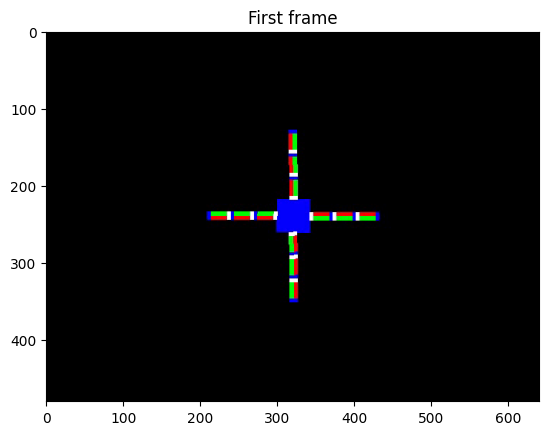

In [20]:
# 1. Loading the video

video_path = "escrime.avi" 
cap = cv2.VideoCapture(video_path)

# 2. Displating the first frame
ret, frame = cap.read()
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame_rgb)
plt.title("First frame")
plt.show()
cap.release()

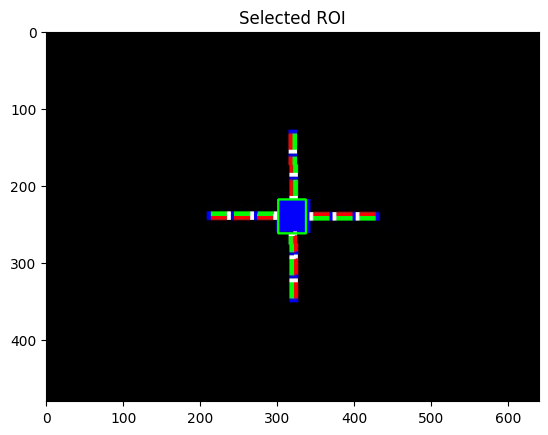

In [21]:
# 3. Selection of the ROI 
'''
Enter to validate the selection
C to cancel
Esc to exit
'''
bbox = cv2.selectROI("Select ROI (Enter to confirm)", frame, fromCenter=False, showCrosshair=True)
cv2.destroyAllWindows()

x, y, w, h = map(int, bbox)
if w == 0 or h == 0:
    raise ValueError("Emptuy selection.")

# 4.Visualisation of the ROI
'''
(x, y) : top-left corner of the rectangle
(x + w, y + h) : bottom-right corner based on width and height
(0, 255, 0) : rectangle color in BGR (green)
2 : thickness of the border in pixels
'''

vis = frame.copy()
cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("Selected ROI")
plt.show()

In [22]:
# 5. Useful variables
roi = frame[y:y+h, x:x+w]                     
center_roi = np.array([x + w/2, y + h/2])  
size_roi = (w, h)                            

print("Centre initial (cx, cy):", center_roi)
print("Taille (w, h):", size_roi)

Centre initial (cx, cy): [319. 240.]
Taille (w, h): (36, 44)


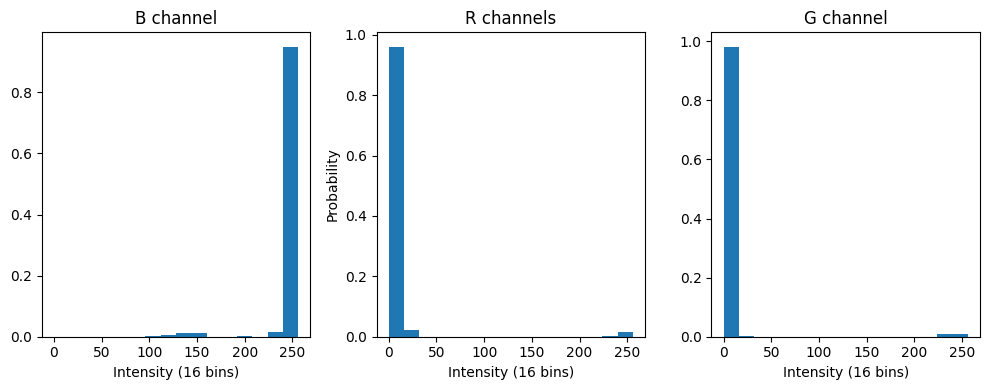

In [23]:
# 6. Computing the histograms for each RGB channel on the ROI

Nb = 16 # number of bins 
'''
Each color channel (R, G, B) has Nb bins
We visualize 1D histograms for R, G, B (Nb bins each) 
L1-normalized (sum = 1) to be used for likelihood comparison
'''
def hist1d_channel(img_rgb, channel, nbins=16):
    '''
    Returns (hist_probs, bin_centers, bin_edges) for one RGB channel
    '''
    vals = img_rgb[:, :, channel].ravel()
    counts, edges = np.histogram(vals, bins=nbins, range=(0, 256))
    counts = counts.astype(np.float32)
    probs = counts / (counts.sum() + 1e-8) # L1 normalization
    centers = 0.5 * (edges[:-1] + edges[1:])
    return probs, centers, edges

# ROI to RGB 
roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)

# Histograms for R, G, B channels
h_B, c_B, e_B = hist1d_channel(roi_rgb, channel=2, nbins=Nb) # Blue
h_R, c_R, e_R = hist1d_channel(roi_rgb, channel=0, nbins=Nb) # Red
h_G, c_G, e_G = hist1d_channel(roi_rgb, channel=1, nbins=Nb) # Green

# Plot 
plt.figure(figsize=(10,4))

# Blue
plt.subplot(1,3,1)
plt.bar(c_B, h_B, width=(c_B[1]-c_B[0]), align='center')
plt.title(f"B channel")
plt.xlabel("Intensity (16 bins)")

# Red
plt.subplot(1,3,2)
plt.bar(c_R, h_R, width=(c_R[1]-c_R[0]), align='center')
plt.title(f"R channels")
plt.xlabel("Intensity (16 bins)")
plt.ylabel("Probability")

# Green
plt.subplot(1,3,3)
plt.bar(c_G, h_G, width=(c_G[1]-c_G[0]), align='center')
plt.title(f"G channel")
plt.xlabel("Intensity (16 bins)")

plt.tight_layout()
plt.show()

In [24]:
# 7. Computing the reference histogram h_ref on the ROI

'''
We build the reference histogram h_ref as the 1D BLUE-channel histogram (since the object to track is blue, 
blue channel is more discriminative)
'''

h_ref = h_B.copy()  # shape = (Nb,)
print("h_ref length:", len(h_ref)) # expected: Nb
print("sum(h_ref):", float(h_ref.sum())) # expected: 1

h_ref length: 16
sum(h_ref): 1.0


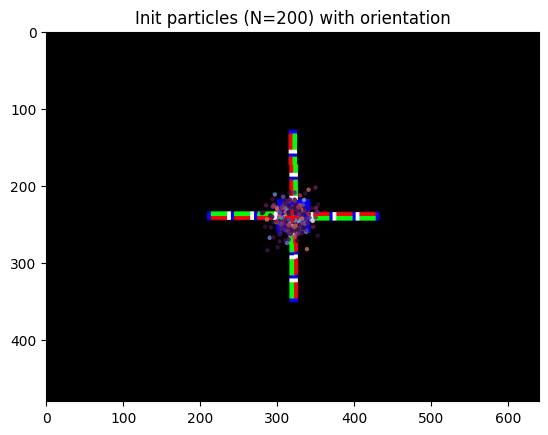

In [25]:
# 8) Initialization of the particles around the initial center


N = 200 # number of particles
sigma_pos = 15 # spread in pixels $
theta0 = 0.0 
sigma_theta = 2.0  # angular variance in degrees

# Initial info from earlier
cx, cy = center_roi # center of ROI
w, h = size_roi # size of ROI
'''
We initialize N particles around the initial object center.
Each particle i has a weight w_i = 1/N
They represent different hypotheses of the object location.
'''

# Particules: [x, y, θ]
particles = np.empty((N, 3), dtype=np.float32)
particles[:, 0] = np.random.normal(cx, sigma_pos, N) # x
particles[:, 1] = np.random.normal(cy, sigma_pos, N) # y
particles[:, 2] = np.random.normal(theta0, sigma_theta, N) # θ 

# Wrap angle to [-180, 180]
particles[:, 2] = ((particles[:, 2] + 180.0) % 360.0) - 180.0

weights = np.ones(N, dtype=np.float32) / N

# Visualisation
plt.figure()
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
sc = plt.scatter(particles[:,0], particles[:,1], c=particles[:,2], s=5, cmap='twilight', alpha=0.8)
plt.scatter(cx, cy, s=100, c='red', marker='+', label='init center')
plt.title(f"Init particles (N={N}) with orientation")
plt.show()

In [ ]:
# 9. Tracking loop (PF + Bhattacharyya + orientation)

# functions in the loop (helpers)

def blue_hist_rotated(img_bgr, x_center, y_center, w, h, theta_deg, nbins=16):
    '''
    Histogramm of the BLUE channel on a rotated patch : we rotate the image around (x_center,y_center),
    then we extract an axis-aligned patch.
    '''
    H, W = img_bgr.shape[:2]
    M = cv2.getRotationMatrix2D((x_center, y_center), theta_deg, 1.0)
    warped = cv2.warpAffine(img_bgr, M, (W, H), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

    x1 = max(0, int(round(x_center - w/2))); x2 = min(W, int(round(x_center + w/2)))
    y1 = max(0, int(round(y_center - h/2))); y2 = min(H, int(round(y_center + h/2)))
    if x2 <= x1 or y2 <= y1:
        return np.full(nbins, 1e-12, dtype=np.float32)
    patch_rgb = cv2.cvtColor(warped[y1:y2, x1:x2], cv2.COLOR_BGR2RGB)
    vals = patch_rgb[:, :, 2].ravel()  # canal Bleu
    counts, _ = np.histogram(vals, bins=nbins, range=(0, 256))
    counts = counts.astype(np.float32) 
    probs = counts / (counts.sum() + 1e-8)
    probs = np.clip(probs, 1e-12, None)
    return probs / probs.sum()

def bhattacharyya(h1, h2):
    bc = np.sum(np.sqrt(h1 * h2))
    bc = np.clip(bc, 0.0, 1.0)
    return np.sqrt(1.0 - bc)

def systematic_resample(weights):
    N = len(weights)
    positions = (np.arange(N) + np.random.rand()) / N
    idx = np.zeros(N, dtype=np.int32)
    cdf = np.cumsum(weights)
    i = j = 0
    while i < N:
        if positions[i] < cdf[j]:
            idx[i] = j; i += 1
        else:
            j += 1
    return idx

def draw_oriented_box(img, cx, cy, w, h, theta_deg, color=(0,255,255), th=2):
    rect = ((float(cx), float(cy)), (float(w), float(h)), float(theta_deg))
    box  = cv2.boxPoints(rect).astype(int)
    cv2.polylines(img, [box], True, color, th)

# Parameters PF
N = particles.shape[0]
w_roi, h_roi = size_roi
lambda_b = 70.0 # likelihood strength
sigma_move = 6.0 # noise in pixels
sigma_theta = 2.0 #angular noise in degrees

# To start cleanly
SHOW_PARTICLES = False
WARMUP_FRAMES  = 4
frame_idx      = 0

''' REDUCE_BY_TWO = True  # traite 1 frame sur 2 '''


# Start video again
cap = cv2.VideoCapture(video_path)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    H, W = frame.shape[:2]

    # A) PREDICTION (warm-up sans bruit pour coller direct à la ROI)
    if frame_idx < WARMUP_FRAMES:
        particles[:, 0] = np.clip(np.random.normal(center_roi[0], 2.0, N), 0, W-1)
        particles[:, 1] = np.clip(np.random.normal(center_roi[1], 2.0, N), 0, H-1)
        particles[:, 2] = np.clip(np.random.normal(0.0, 1.0, N), -180, 180)
    else:
        particles[:, 0] += np.random.normal(0, sigma_move, N)
        particles[:, 1] += np.random.normal(0, sigma_move, N)
        particles[:, 2] += np.random.normal(0, sigma_theta, N)

    # wrap & bornes
    particles[:, 2] = ((particles[:, 2] + 180.0) % 360.0) - 180.0
    particles[:, 0] = np.clip(particles[:, 0], 0, W-1)
    particles[:, 1] = np.clip(particles[:, 1], 0, H-1)

    # B) CORRECTION (mesure dépendante de θ)
    for i in range(N):
        xi, yi, ti = particles[i, 0], particles[i, 1], particles[i, 2]
        h_cand = blue_hist_rotated(frame, xi, yi, w_roi, h_roi, ti, nbins=Nb)
        d = bhattacharyya(h_ref, h_cand)
        weights[i] = np.exp(-lambda_b * (d**2))

    # sécurités numériques
    if not np.isfinite(weights).all():
        weights[:] = 1.0 / N
    s = float(weights.sum())
    if s <= 1e-12:
        weights[:] = 1.0 / N
    else:
        weights /= s

    # C) ESTIMATION (x, y, θ — moyenne circulaire pour θ)
    cx_est = float(np.sum(particles[:, 0] * weights))
    cy_est = float(np.sum(particles[:, 1] * weights))
    ang    = np.deg2rad(particles[:, 2])
    theta_est = float(np.rad2deg(np.arctan2(np.sum(np.sin(ang)*weights),
                                            np.sum(np.cos(ang)*weights))))



    # D) RESAMPLING
    idx = systematic_resample(weights)
    particles = particles[idx]
    weights[:] = 1.0 / N

    # E) VISU (pas de particules visibles)
    vis = frame.copy()
    draw_oriented_box(vis, cx_est, cy_est, w_roi, h_roi, theta_est, color=(0,0,255), th=2)
    cv2.imshow("Particle Filter Tracking", vis)
    frame_idx += 1
    key = cv2.waitKey(1) & 0xFF
    '''
    if REDUCE_BY_TWO:
    cap.grab()  # on traite 1/2 des frames 
    '''
    if key in (27, ord('q')):
        break


cap.release()
cv2.destroyAllWindows()



Tracking metrics (robustes)
Frames évaluées: 200
BC moyen (0-1, plus haut = mieux): 0.982
BC médian: 0.983
% frames BC ≥ 0.80: 100.0%
ESS_norm moyen (0-1): 0.25


these metrics are innapropriate : i thaught that i could compute some but we don't have the ground truth coordinates! (cf report)

## Test : we want to change some parameters to see how the metrics evolve
 We simply change the parameters in the notebook and run all again. Here we kepts the initial parameters for the final version. 

In [ ]:
# 9. BIS Tracking loop (now with residual sampling)

# functions in the loop (helpers)

def residual_resample(weights):
    '''
    Residual resampling:
    1) copies = floor(N * w_i) déterministes
    2) le reste via multinomial sur les résidus
    Retourne les indices sélectionnés (taille N).
    '''
    N = len(weights)
    w = np.asarray(weights, dtype=np.float64)
    w = w / (w.sum() + 1e-12)

    # 1) Partie déterministe
    copies = np.floor(N * w).astype(int)
    num_copies = copies.sum()

    # 2) Résidus normalisés
    residual = w * N - copies
    residual_sum = residual.sum()
    if residual_sum > 1e-12:
        residual = residual / residual_sum
        # tirage multinomial pour compléter jusqu'à N
        remainder = np.random.choice(np.arange(N), size=N - num_copies, p=residual)
    else:
        remainder = np.array([], dtype=int)

    # concatène indices: copies déterministes + tirages résiduels
    idx = np.repeat(np.arange(N), copies)
    if remainder.size:
        idx = np.concatenate([idx, remainder])

    # sécurité 
    if idx.size < N:
        extra = np.random.choice(np.arange(N), size=N - idx.size)
        idx = np.concatenate([idx, extra])
    elif idx.size > N:
        idx = idx[:N]

    return idx


# Parameters PF
N = particles.shape[0]
w_roi, h_roi = size_roi
lambda_b = 70.0 # likelihood strength
sigma_move = 6.0 # noise in pixels
sigma_theta = 2.0 #angular noise in degrees

# To start cleanly
SHOW_PARTICLES = False
WARMUP_FRAMES  = 4
frame_idx      = 0



# Start video again
cap = cv2.VideoCapture(video_path)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    H, W = frame.shape[:2]

    # A) PREDICTION (warm-up sans bruit pour coller direct à la ROI)
    if frame_idx < WARMUP_FRAMES:
        particles[:, 0] = np.clip(np.random.normal(center_roi[0], 2.0, N), 0, W-1)
        particles[:, 1] = np.clip(np.random.normal(center_roi[1], 2.0, N), 0, H-1)
        particles[:, 2] = np.clip(np.random.normal(0.0, 1.0, N), -180, 180)
    else:
        particles[:, 0] += np.random.normal(0, sigma_move, N)
        particles[:, 1] += np.random.normal(0, sigma_move, N)
        particles[:, 2] += np.random.normal(0, sigma_theta, N)

    # wrap & bornes
    particles[:, 2] = ((particles[:, 2] + 180.0) % 360.0) - 180.0
    particles[:, 0] = np.clip(particles[:, 0], 0, W-1)
    particles[:, 1] = np.clip(particles[:, 1], 0, H-1)

    # B) CORRECTION (mesure dépendante de θ)
    for i in range(N):
        xi, yi, ti = particles[i, 0], particles[i, 1], particles[i, 2]
        h_cand = blue_hist_rotated(frame, xi, yi, w_roi, h_roi, ti, nbins=Nb)
        d = bhattacharyya(h_ref, h_cand)
        weights[i] = np.exp(-lambda_b * (d**2))

    # sécurités numériques
    if not np.isfinite(weights).all():
        weights[:] = 1.0 / N
    s = float(weights.sum())
    if s <= 1e-12:
        weights[:] = 1.0 / N
    else:
        weights /= s

    # C) ESTIMATION (x, y, θ — moyenne circulaire pour θ)
    cx_est = float(np.sum(particles[:, 0] * weights))
    cy_est = float(np.sum(particles[:, 1] * weights))
    ang    = np.deg2rad(particles[:, 2])
    theta_est = float(np.rad2deg(np.arctan2(np.sum(np.sin(ang)*weights),
                                            np.sum(np.cos(ang)*weights))))

    # D) RESAMPLING
    idx = residual_resample(weights)
    particles = particles[idx]
    weights[:] = 1.0 / N

    # E) VISU (pas de particules visibles)
    vis = frame.copy()
    draw_oriented_box(vis, cx_est, cy_est, w_roi, h_roi, theta_est, color=(0,0,255), th=2)
    cv2.imshow("Particle Filter Tracking", vis)
    frame_idx += 1
    key = cv2.waitKey(1) & 0xFF
    if key in (27, ord('q')):
        break



cap.release()
cv2.destroyAllWindows()



Tracking metrics (robustes)
Frames évaluées: 200
BC moyen (0-1, plus haut = mieux): 0.982
BC médian: 0.982
% frames BC ≥ 0.80: 100.0%
ESS_norm moyen (0-1): 0.25


these metrics are innapropriate : i thaught that i could compute some but we don't have the ground truth coordinates! (cf report)